In [97]:
#!pip install splink

In [2]:
import duckdb
from tqdm.auto import tqdm 
import pandas as pd

connection_source = duckdb.connect(database="../dbt/database_name.duckdb", read_only = True)

In [3]:
# OK : Filtrer les propriétaires ayant un logements vacant dans la prod (lovac 2024)
# Logement est le lien entre un propriétaire national et départemental 
# Aller chercher les logements via les ID locaux dans les fichiers fonciers
# Aller chercher les logements via les ID locaux dans la prod 

In [6]:
# Queries pour charger les DataFrames
query_owners = """ 
WITH ff_idlocal_idprocte AS (
    SELECT ff_idlocal, ff_idprocpte
    FROM raw_lovac_2024
    UNION ALL
    SELECT ff_idlocal, ff_idprocpte
    FROM raw_lovac_2023
),
ff_idprocte AS (
    SELECT
        ff_idprocpte,
        ff_idlocal
    FROM ff_idlocal_idprocte
),
ff_unique_owner_ids AS (
    SELECT
        o.ff_owner_idpersonne,
        unnest(o.ff_owner_idprocpte) AS idprocpte
    FROM main_int.int_ff_owners_dedup o
),
ff_data AS (
    SELECT oi.ff_owner_idpersonne, oi.idprocpte, ids.ff_idlocal
    FROM ff_unique_owner_ids oi
    LEFT JOIN ff_idprocte ids ON ids.ff_idprocpte = oi.idprocpte
),
prod_owners AS (
    SELECT
        o.id,
        ph.local_id
    FROM main_stg.stg_production_owners o
    JOIN production.ban_addresses ba
        ON ba.address_kind = 'Owner' AND ba.ref_id = o.id
    JOIN main_stg.stg_production_owners_housing poh
        ON poh.owner_id = o.id
    JOIN main_stg.stg_production_housing ph
        ON poh.housing_id = ph.id
    WHERE
        (occupancy_source = 'V' OR occupancy = 'V')
        AND data_file_years IS NOT NULL
        AND list_contains(data_file_years, 'lovac-2024')
        AND o.birth_date IS NOT NULL
        AND idpersonne IS NULL
),
data_to_check AS (
    SELECT prod_owners.id,
            fd.ff_owner_idpersonne,
            array_agg(DISTINCT fd.ff_idlocal) AS local_ids
    FROM prod_owners
    JOIN ff_data fd ON fd.ff_idlocal = prod_owners.local_id
    GROUP BY prod_owners.id, fd.ff_owner_idpersonne
), input_data AS (
SELECT dtc.id
    , dtc.ff_owner_idpersonne
    , dtc.local_ids
    , ipo.full_name as prod_full_name
    , ipo.birth_date as prod_birth_date
    , ba.city as prod_city
    , coalesce(ba.postal_code, ipo.postal_code) as prod_postcode
    , coalesce(cleaned_address, ipo.address_dgfip[0]) as prod_address
    , ifo.ff_owner_fullname as ff_fullname
    , ifo.ff_owner_birth_date as ff_birth_date
    , ifo.ff_owner_firstname as ff_firstname
    , ifo.ff_owner_lastname as ff_lastname
    , ifo.ff_owner_firstnames as ff_firstnames
    , ifo.ff_owner_birth_lastname as ff_birth_lastname
    , ifo.ff_owner_city as ff_city
    , ifo.ff_owner_postal_code as ff_postcode
    , coalesce(ifo.ff_owner_address_1, '') || ' ' || coalesce(ifo.ff_owner_address_2, '') || ' ' || coalesce(ifo.ff_owner_address_3, '') || ' ' || coalesce(ifo.ff_owner_address_4, '') AS ff_address,

FROM data_to_check dtc
JOIN main_int.int_production_owners ipo ON ipo.id = dtc.id
JOIN main_int.int_ff_owners_dedup ifo ON ifo.ff_owner_idpersonne = dtc.ff_owner_idpersonne
LEFT JOIN production.ban_addresses ba ON ba.ref_id = ipo.id AND ba.address_kind = 'Owner'
),
scored_data AS (
    SELECT *,
        -- Score for owner_fullname
        CASE
            WHEN prod_full_name IS NULL OR ff_fullname IS NULL THEN 0
            ELSE jaro_winkler_similarity(prod_full_name, ff_fullname)
        END AS owner_fullname_score,
        CASE
            WHEN prod_full_name IS NULL OR ff_firstname IS NULL THEN 0
            ELSE jaro_winkler_similarity(prod_full_name, ff_firstname)
        END AS owner_firstname_score,
        CASE
            WHEN prod_full_name IS NULL OR ff_firstnames IS NULL THEN 0
            ELSE jaro_winkler_similarity(prod_full_name, ff_firstnames)
        END AS owner_firstnames_score,
        CASE
            WHEN prod_full_name IS NULL OR ff_lastname IS NULL THEN 0
            ELSE jaro_winkler_similarity(prod_full_name, ff_lastname)
        END AS owner_last_name_score,
        CASE
            WHEN prod_full_name IS NULL OR ff_birth_lastname IS NULL THEN 0
            ELSE jaro_winkler_similarity(prod_full_name, ff_birth_lastname)
        END AS owner_birth_last_name_score,
        CASE 
            WHEN prod_full_name IS NULL OR ff_lastname IS NULL THEN 0
            WHEN POSITION(LOWER(ff_lastname) IN LOWER(prod_full_name)) > 0 THEN 1
        ELSE 0
        END AS owner_last_name_in_fullname_score,
        CASE 
            WHEN prod_full_name IS NULL OR ff_firstname IS NULL THEN 0
            WHEN POSITION(LOWER(ff_firstname) IN LOWER(prod_full_name)) > 0 THEN 1
        ELSE 0
        END AS owner_firstname_in_fullname_score,
        CASE 
            WHEN prod_full_name IS NULL OR ff_birth_lastname IS NULL THEN 0
            WHEN POSITION(LOWER(ff_birth_lastname) IN LOWER(prod_full_name)) > 0 THEN 1
        ELSE 0
        END AS owner_ff_birth_lastname_in_fullname_score,        
        -- Score for owner_birth_date
        CASE
            WHEN prod_birth_date IS NULL OR ff_birth_date IS NULL THEN 0
            WHEN prod_birth_date = ff_birth_date THEN 1
            WHEN damerau_levenshtein(CAST(prod_birth_date AS TEXT), CAST(ff_birth_date AS TEXT)) <= 1 THEN 0.9
            WHEN ABS(EPOCH(prod_birth_date) - EPOCH(ff_birth_date)) <= 87660.0 THEN 0.95 -- Diff <= 1 day
            WHEN ABS(EPOCH(prod_birth_date) - EPOCH(ff_birth_date)) <= 2629800.0 THEN 0.80 -- Diff <= 1 month
            ELSE 0
        END AS owner_birth_date_score,
        DATEDIFF('days', ff_birth_date, prod_birth_date) AS owner_birth_date_diff_score,
        -- Score for owner_postcode
        CASE
            WHEN prod_postcode IS NULL OR ff_postcode IS NULL OR prod_postcode = '' OR ff_postcode = '' THEN 0
            WHEN prod_postcode = ff_postcode THEN 1
            WHEN NULLIF(regexp_extract(prod_postcode, '^[A-Za-z]{1,2}[0-9][A-Za-z0-9]? [0-9]', 0), '') = NULLIF(regexp_extract(ff_postcode, '^[A-Za-z]{1,2}[0-9][A-Za-z0-9]? [0-9]', 0), '') THEN 0.90 -- Match on sector
            WHEN NULLIF(regexp_extract(prod_postcode, '^[A-Za-z]{1,2}[0-9][A-Za-z0-9]?', 0), '') = NULLIF(regexp_extract(ff_postcode, '^[A-Za-z]{1,2}[0-9][A-Za-z0-9]?', 0), '') THEN 0.80 -- Match on district
            WHEN NULLIF(regexp_extract(prod_postcode, '^[A-Za-z]{1,2}', 0), '') = NULLIF(regexp_extract(ff_postcode, '^[A-Za-z]{1,2}', 0), '') THEN 0.70 -- Match on area
            ELSE 0
        END AS owner_postal_code_score,
        
        -- Score for owner_address
        CASE
            WHEN prod_address IS NULL OR ff_address IS NULL OR ff_address = '' OR prod_address = '' THEN 0
            ELSE jaro_winkler_similarity(prod_address, ff_address)
        END AS owner_address_score,
                -- Score for owner_city
        CASE
            WHEN prod_city IS NULL OR ff_city IS NULL OR ff_city = '' OR prod_city = '' THEN 0
            ELSE jaro_winkler_similarity(prod_city, ff_city)
        END AS owner_city_score, 
        CASE  
            WHEN POSITION(LOWER(prod_city) IN LOWER(ff_city)) > 0 THEN 1
            WHEN POSITION(LOWER(ff_city) IN LOWER(prod_city)) > 0 THEN 1
            ELSE 0
        END AS owner_city_in_city_score
    FROM input_data
)
SELECT *
FROM scored_data;
"""


df_ff_owners = connection_source.execute(query_owners).fetchdf()
print(df_ff_owners.shape)

connection_source.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(2284662, 31)


In [42]:
df_ff_owners["id"] = df_ff_owners["id"].astype(str)

# Process model

In [44]:
df = pd.read_csv(
    '/Users/raphaelcourivaud/Downloads/Matching Propriétaires Feuille 1.csv'
    )[["id", "ff_owner_idpersonne","validation"]].query("validation.isin(['OK', 'NOK'])")

In [18]:
df_ff_owners.filter(regex='score')

,owner_fullname_score,owner_firstname_score,owner_firstnames_score,owner_last_name_score,owner_birth_last_name_score,owner_last_name_in_fullname_score,owner_firstname_in_fullname_score,owner_ff_birth_lastname_in_fullname_score,owner_birth_date_score,owner_birth_date_diff_score,owner_postal_code_score,owner_address_score,owner_city_score,owner_city_in_city_score
0,0.539755,0.380952,0.380952,0.505952,0.725397,0,0,1,0.00,-13025.0,0.0,0.539479,0.000000,1
1,0.346764,0.000000,0.382784,0.414530,0.414530,1,1,1,0.95,0.0,1.0,0.527778,0.000000,1
2,0.930476,0.788889,0.788889,0.000000,0.853333,0,1,1,0.95,0.0,0.0,0.696970,0.000000,0
3,0.844563,0.738811,0.738811,0.754545,0.754545,1,1,1,0.95,0.0,1.0,0.702614,0.398810,1
4,0.606807,0.428230,0.499711,0.654882,0.654882,1,0,1,0.00,1304.0,1.0,0.668651,0.384533,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284657,0.827737,0.629149,0.629149,0.848485,0.848485,1,0,1,0.00,-620.0,0.0,0.538889,0.000000,0
2284658,0.647245,0.539160,0.539160,0.570175,0.570175,0,0,0,0.00,2262.0,0.0,0.509343,0.000000,0
2284659,0.684967,0.411111,0.529293,0.866667,0.866667,1,0,1,0.00,1316.0,0.0,0.453288,0.000000,0
2284660,0.635096,0.602801,0.530906,0.788235,0.788235,1,0,1,0.00,-7714.0,1.0,0.588816,0.370485,0


In [65]:
df_for_model = df_ff_owners.merge(df, on = ["id", "ff_owner_idpersonne"], how = "inner")

In [66]:
X = df_for_model.filter(regex='score').fillna(0)
y = df_for_model["validation"]

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [75]:
lr = DecisionTreeClassifier()

lr.fit(X_train, y_train)

DecisionTreeClassifier()

In [76]:
# classificiation report 

from sklearn.metrics import classification_report

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         NOK       0.97      0.99      0.98        85
          OK       0.99      0.96      0.97        79

    accuracy                           0.98       164
   macro avg       0.98      0.98      0.98       164
weighted avg       0.98      0.98      0.98       164



In [77]:
lr.fit(X, y)

DecisionTreeClassifier()

In [78]:
to_predict = df_ff_owners.filter(regex='score').fillna(0)

In [79]:
predicted = lr.predict(to_predict)

In [85]:
df_ff_owners["predicted"] = predicted
df_ff_owners["predicted_proba"] = lr.predict_proba(to_predict)[:,1]


In [83]:
df_ff_owners[["id", "ff_owner_idpersonne", "predicted", "prod_full_name", "ff_fullname", "prod_birth_date", "ff_birth_date"]].to_csv("predicted.csv", index = False)

In [89]:
df_ff_owners.query("predicted == 'OK'")[["id", "ff_owner_idpersonne", "predicted"]].to_csv("unified_owners.csv", index = False)

In [91]:
pwd 

'/Users/raphaelcourivaud/dev/zlv/zero-logement-vacant/analytics/exploration'

In [20]:
from matplotlib import pyplot as plt

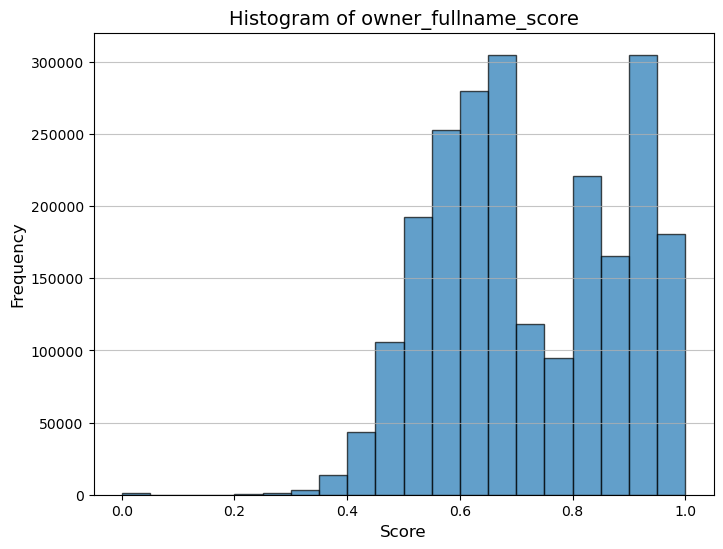

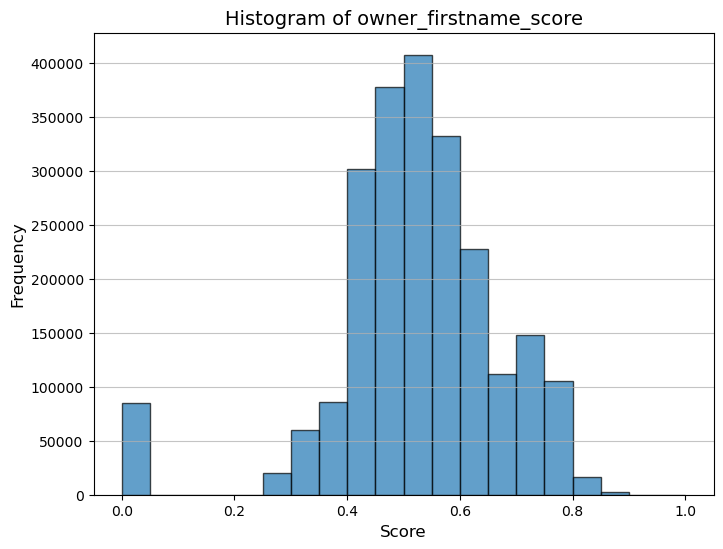

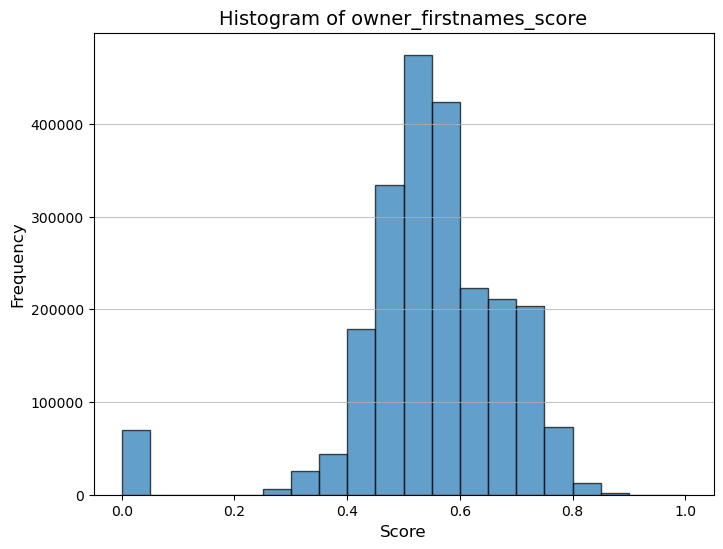

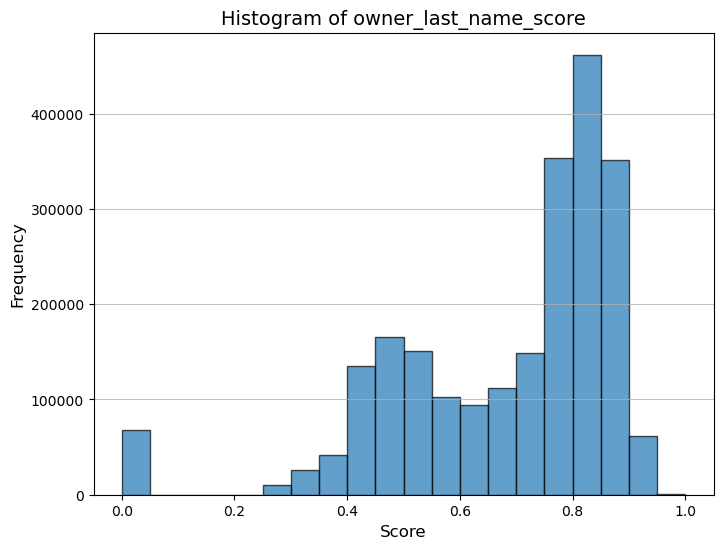

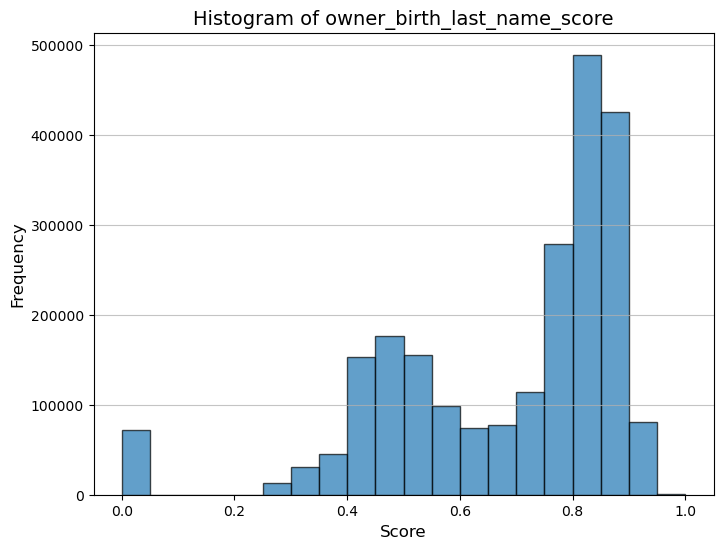

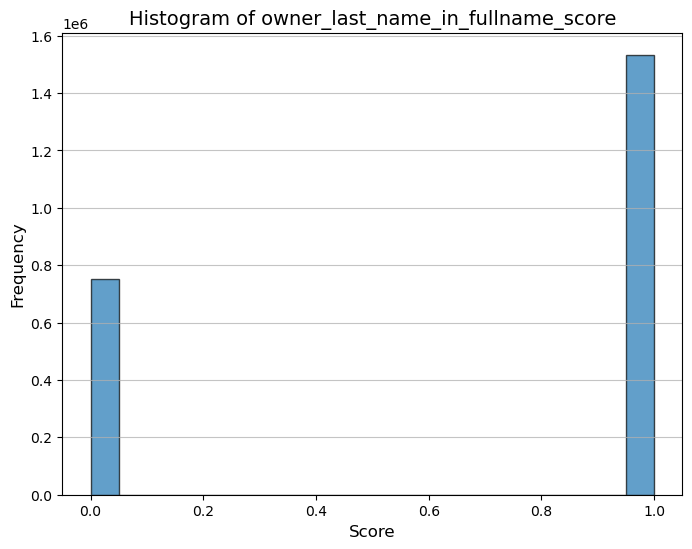

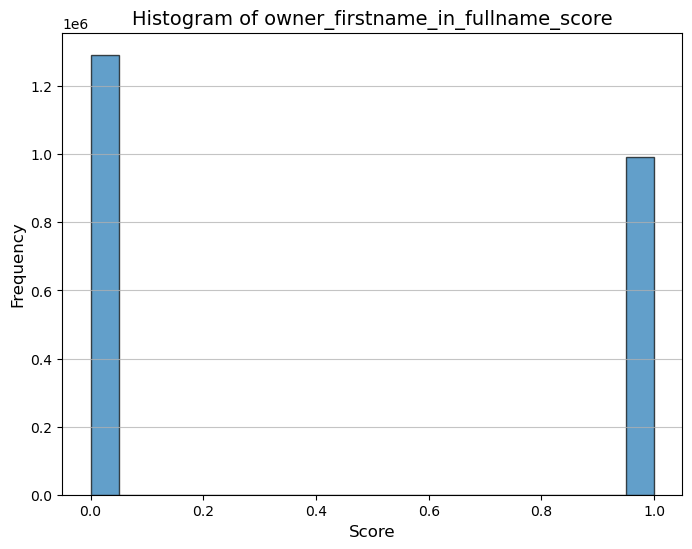

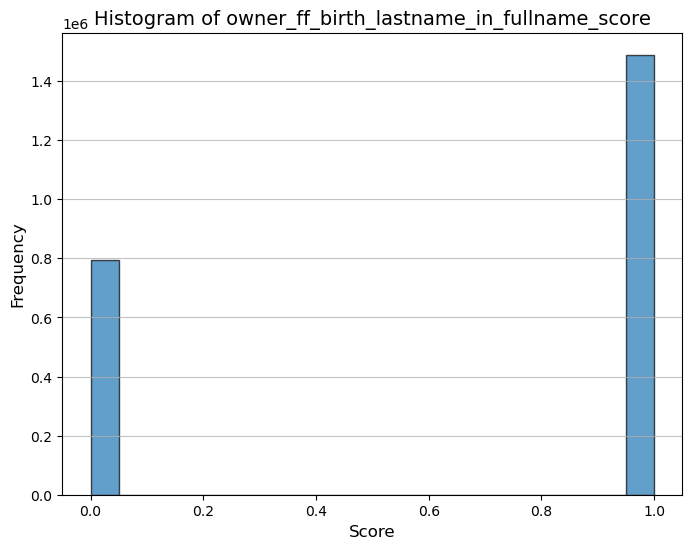

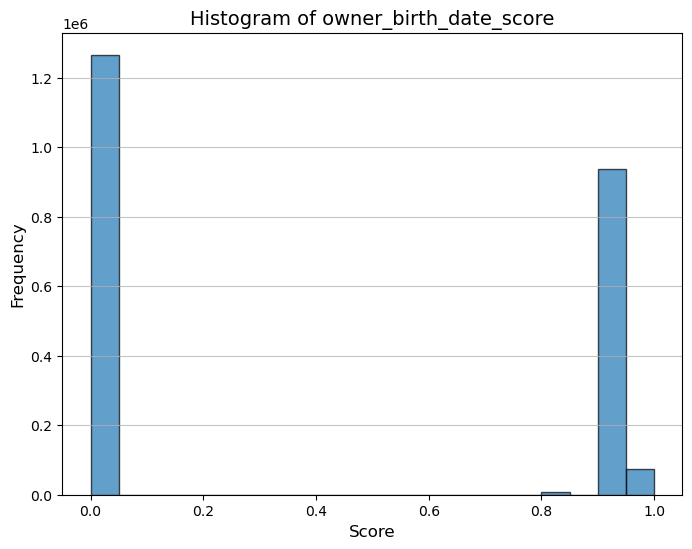

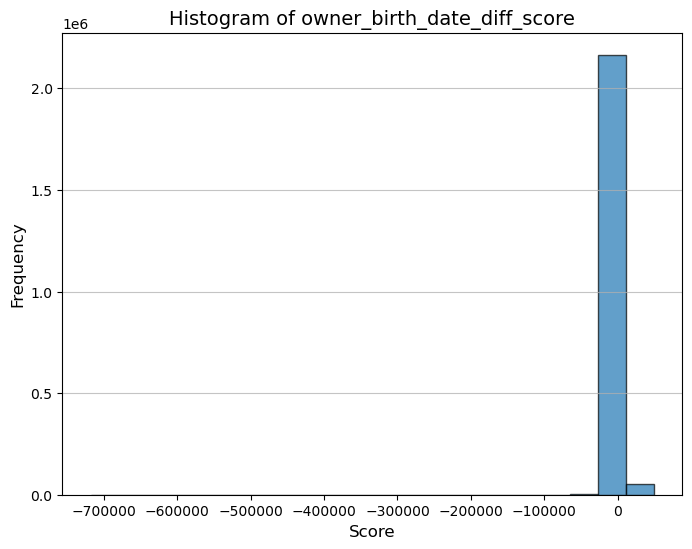

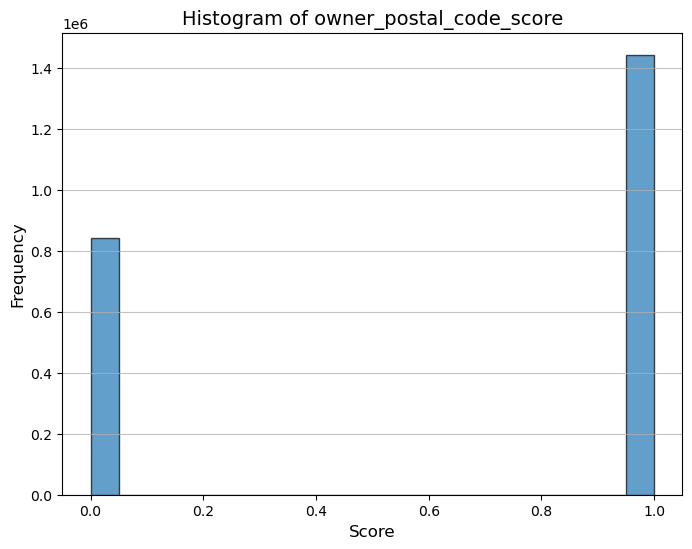

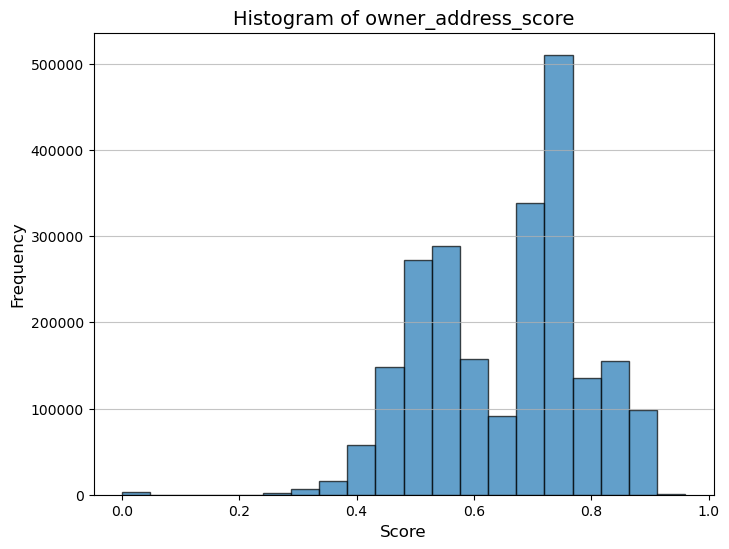

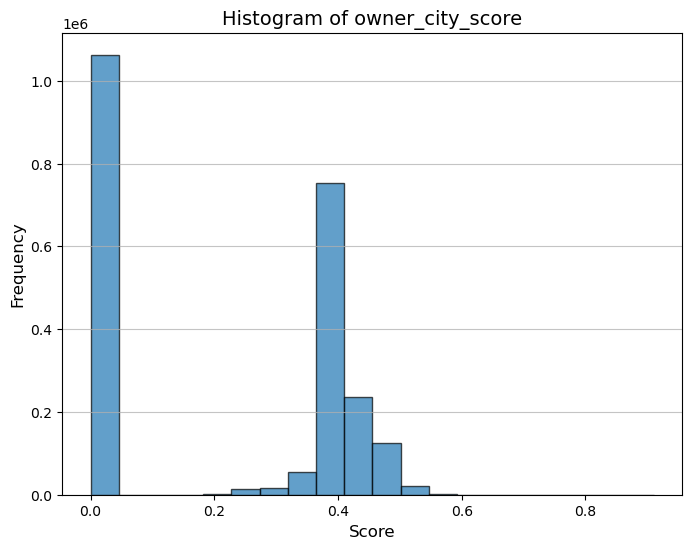

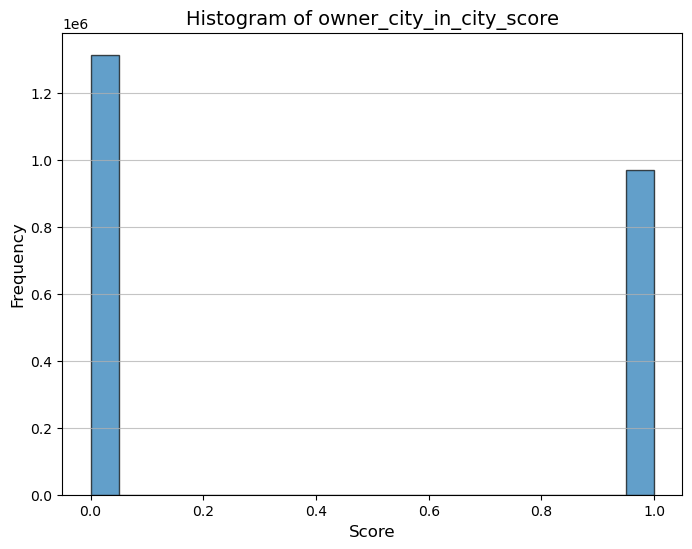

In [21]:
for column in df_ff_owners.filter(regex="score").columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df_ff_owners[column], bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {column}', fontsize=14)
    plt.xlabel('Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [106]:
df_ff_owners.sample(1000).to_clipboard(index=False)

In [ ]:
df_ff_owners.columns1

Index(['id', 'ff_owner_idpersonne', 'local_ids', 'prod_full_name',
       'prod_birth_date', 'prod_city', 'prod_postcode', 'prod_address',
       'ff_fullname', 'ff_birth_date', 'ff_firstname', 'ff_lastname',
       'ff_city', 'ff_postcode', 'ff_address', 'owner_fullname_score',
       'owner_firstname_score', 'owner_last_name_score',
       'owner_birth_date_score', 'owner_postal_code_score',
       'owner_address_score', 'owner_address_city'],
      dtype='object')

<Axes: >

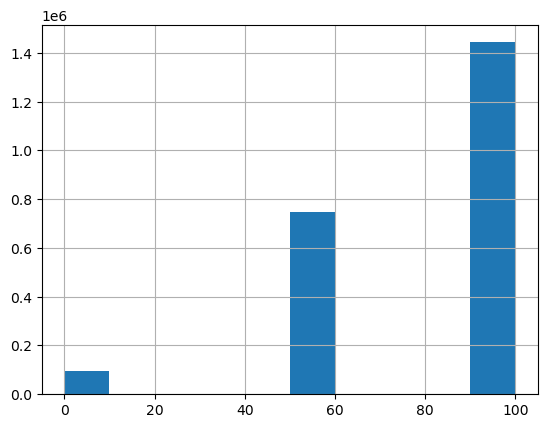

In [ ]:
df_ff_owners.owner_postal_code_score.hist()